# 02_group_analysis.ipynb — y-grouped sensor statistics

本 Notebook 聚焦 **以 `Pass/Fail` 為群組** 的感測器統計分析，包含：
- 自動偵測目標欄位（預設找 `Pass/Fail` / `y`）
- 兩群（Pass vs Fail）**均值、標準差、缺失比**彙整表
- **效果量**（Standardized Mean Difference, SMD）
- （若可用）**Welch t 檢定**與 **Benjamini–Hochberg** 多重比較校正
- 重要感測器的視覺化（Top-|effect|、火山圖、群組均值熱圖）

> 視覺化僅使用 `matplotlib`，未使用 seaborn。


裡面包含：

- 自動偵測 Pass/Fail 目標欄位與數值型感測器
- 以 Pass vs Fail 分組的 均值 / 標準差 / 缺失比彙整表（並存檔至 outputs/）
- 效果量 SMD 計算，並（若環境可用）進行 Welch t 檢定 + BH 假發現率校正
- 視覺化（僅用 matplotlib）：Top-|SMD| 長條圖、火山圖（若有 p 值）、群組均值熱圖
- 後續建議與注意事項

In [4]:
# === Imports & Settings ===
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 顯示設定
pd.set_option('display.max_columns', 120)
pd.set_option('display.width', 180)

%matplotlib inline

# 檢查是否可用 scipy（若無則僅輸出效果量等無 p 值的指標）
try:
    from scipy import stats
    SCIPY_AVAILABLE = True
except Exception as e:
    SCIPY_AVAILABLE = False
    print("scipy 不可用：僅計算效果量（SMD），略過 p 值與 t 檢定。")


In [5]:
# === Load Data ===
candidate_paths = [
    os.path.join('data', 'uci-secom.csv'),
    '../data/uci-secom.csv'
]

csv_path = None
for p in candidate_paths:
    if os.path.exists(p):
        csv_path = p
        break

if csv_path is None:
    raise FileNotFoundError("找不到 uci-secom.csv，請放到 ./data 或使用上傳路徑。")

df = pd.read_csv(csv_path)
print('Loaded:', csv_path, ' shape=', df.shape)

# 目標欄位偵測
target_candidates = [c for c in df.columns if str(c).lower() in ['pass/fail', 'y', 'target', 'label']]
target_col = target_candidates[0] if len(target_candidates) > 0 else None
if target_col is None:
    raise ValueError("未找到目標欄位（期望為 Pass/Fail 或 y）。請確認欄位命名。")
print('Target column:', target_col)

# 數值型感測器欄位（排除非數值與目標欄位與明顯時間欄位）
sensor_cols = []
for c in df.columns:
    if c == target_col:
        continue
    if str(c).lower() == 'time':
        continue
    if pd.api.types.is_numeric_dtype(df[c]):
        sensor_cols.append(c)

print('Numeric sensor columns:', len(sensor_cols))


Loaded: ../data/uci-secom.csv  shape= (1567, 592)
Target column: Pass/Fail
Numeric sensor columns: 590


In [6]:
# === Target Preparation ===
# SECOM 常見標記: 1=Pass, -1=Fail（或 0/1 類似標記）
y = df[target_col]

# 嘗試將 y 正規化為二群：pass_group, fail_group
# 規則：優先辨識 {-1,1}；若是 {0,1} 則 1 視為 Positive(Fail or Pass 需檢視資料定義)
vals = pd.Series(y.dropna().unique()).sort_values().tolist()
print('Unique y values (non-null):', vals)

# 根據常見 SECOM 設定：1=Pass, -1=Fail
# 若資料實際相反，請視需要調整 mapping
mapping = {1: 'PASS', -1: 'FAIL', 0: 'FAIL'}
y_mapped = y.map(lambda v: mapping.get(v, v))
df['_y_group_'] = y_mapped

group_counts = df['_y_group_'].value_counts(dropna=False)
print('Group counts:\n', group_counts)


Unique y values (non-null): [-1, 1]
Group counts:
 _y_group_
FAIL    1463
PASS     104
Name: count, dtype: int64


In [7]:
# === Grouped Summary (mean/std/missing) ===
def grouped_stats(df, cols, group_col):
    grp = df.groupby(group_col)
    mean_df = grp[cols].mean(numeric_only=True)
    std_df  = grp[cols].std(numeric_only=True)
    miss_df = grp[cols].apply(lambda g: g.isna().mean())
    # MultiIndex columns
    out = pd.concat({
        'mean': mean_df,
        'std': std_df,
        'missing_ratio': miss_df
    }, axis=1)
    return out

gstats = grouped_stats(df, sensor_cols, '_y_group_')
print('Grouped stats shape:', gstats.shape)
gstats.head(10)


Grouped stats shape: (2, 1770)


mean                                                                                                                                                   \
                     0            1            2            3         4      5           6         7         8         9        10        11          12   13        14   
_y_group_                                                                                                                                                                 
FAIL       3014.947316  2495.906115  2200.554886  1399.290292  4.404698  100.0  101.085773  0.121790  1.462309 -0.000715  0.000062  0.964461  199.961995  0.0  9.056841   
PASS       3007.526250  2495.059709  2200.441877  1355.781435  1.303405  100.0  101.490972  0.122257  1.470619 -0.002608  0.001318  0.962831  199.883958  0.0  8.282811   

                                                                                                                                                                                  \
                   15        16        17          18         19        20           21           22           23          24        25        26        27         28        29   
_y_group_                                                                                                                                                                          
FAIL       413.099290  9.906092  0.971475  190.053923  12.479256  1.404951 -5636.437585  2705.158174 -3811.035568 -284.441518  1.205567  1.942575  6.648314  69.598032  2.364333   
PASS       412.899965  9.928818  0.971006  189.955131  12.506132  1.406513 -5362.274272  2617.339806 -3739.078479 -499.539641  1.179400  1.880300  6.501141  68.101406  2.392662   

                                                                                                                                                                         \
                 30        31         32        33         34         35         36         37         38          39         40        41    42          43         44   
_y_group_                                                                                                                                                                 
FAIL       0.183832  3.680182  85.309299  8.931262  50.581839  64.564218  49.418170  66.217922  86.830311  118.680579  68.239842  3.351492  70.0  355.572932  10.032247   
PASS       0.188797  3.573929  85.733464  9.368188  50.593880  64.437273  49.406129  66.268387  86.924659  118.665148  63.270606  3.374849  70.0  355.060543  10.015958   

                                                                                                                                                                    ...  \
                   45          46        47          48   49          50          51   52        53        54           55        56        57        58        59  ...   
_y_group_                                                                                                                                                           ...   
FAIL       136.725590  733.703357  1.176534  139.990648  1.0  632.289172  157.323447  0.0  4.592873  4.838299  2856.233562  0.928734  0.949237  4.592049  2.563464  ...   
PASS       136.988643  733.243414  1.197977  139.713336  1.0  631.762527  158.792243  0.0  4.594369  4.841689  2855.300971  0.930488  0.948907  4.611206  8.515123  ...   

          missing_ratio                                                                                                                                                        \
                    530       531       532       533       534       535       536       537       538       539       540       541       542       543       544       545   
_y_group_                                                                                                                                                                       
FAIL           0.0

In [8]:
# === Effect Size (SMD) & Welch t-tests (optional) ===
# Standardized Mean Difference: (m1 - m2) / pooled_std
def compute_effects(df, cols, group_col, group_a='PASS', group_b='FAIL'):
    a = df[df[group_col] == group_a][cols]
    b = df[df[group_col] == group_b][cols]
    m_a = a.mean(numeric_only=True)
    m_b = b.mean(numeric_only=True)
    s_a = a.std(numeric_only=True)
    s_b = b.std(numeric_only=True)
    # pooled std (unbiased)
    pooled = np.sqrt((s_a**2 + s_b**2) / 2.0)
    smd = (m_a - m_b) / pooled.replace(0, np.nan)
    out = pd.DataFrame({'SMD': smd})

    if 'PASS' in df[group_col].unique() and 'FAIL' in df[group_col].unique():
        if SCIPY_AVAILABLE:
            pvals = []
            for c in cols:
                xa = a[c].dropna().values
                xb = b[c].dropna().values
                if len(xa) >= 2 and len(xb) >= 2:
                    # Welch's t-test
                    t, p = stats.ttest_ind(xa, xb, equal_var=False, nan_policy='omit')
                else:
                    p = np.nan
                pvals.append(p)
            out['p_value'] = pvals
            # Benjamini–Hochberg (FDR) correction
            p = out['p_value'].copy()
            m = p.notna().sum()
            if m > 0:
                ranks = p.rank(method='first')
                bh = (p * m) / ranks
                # enforce monotonicity
                order = bh.sort_values().index
                bh_sorted = bh.loc[order].cummin()
                out['p_adj_bh'] = bh_sorted.reindex(out.index)
    return out

effects_df = compute_effects(df, sensor_cols, '_y_group_', 'PASS', 'FAIL')
effects_df.sort_values('SMD', key=lambda s: s.abs(), ascending=False).head(10)


c:\Users\jackl\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


,SMD,p_value,p_adj_bh
111,-0.600772,1.476038e-04,0.000032
59,0.590135,2.627138e-07,0.000032
103,0.571259,6.059669e-07,0.000032
158,0.571032,1.142063e-01,0.000032
293,0.517404,1.687571e-01,0.000032
85,-0.479342,1.510031e-01,0.000032
129,0.477981,6.837903e-08,0.000032
28,-0.444390,1.876330e-05,0.000032
510,0.427267,4.554045e-04,0.000032
316,-0.384043,8.276539e-05,0.000032


In [ ]:
# === Save Outputs ===
out_dir = 'outputs'
os.makedirs(out_dir, exist_ok=True)

gstats_path = os.path.join(out_dir, 'grouped_stats.csv')
effects_path = os.path.join(out_dir, 'effects.csv')

gstats.to_csv(gstats_path, index=True)
effects_df.to_csv(effects_path, index=True)

print('Saved:', gstats_path)
print('Saved:', effects_path)


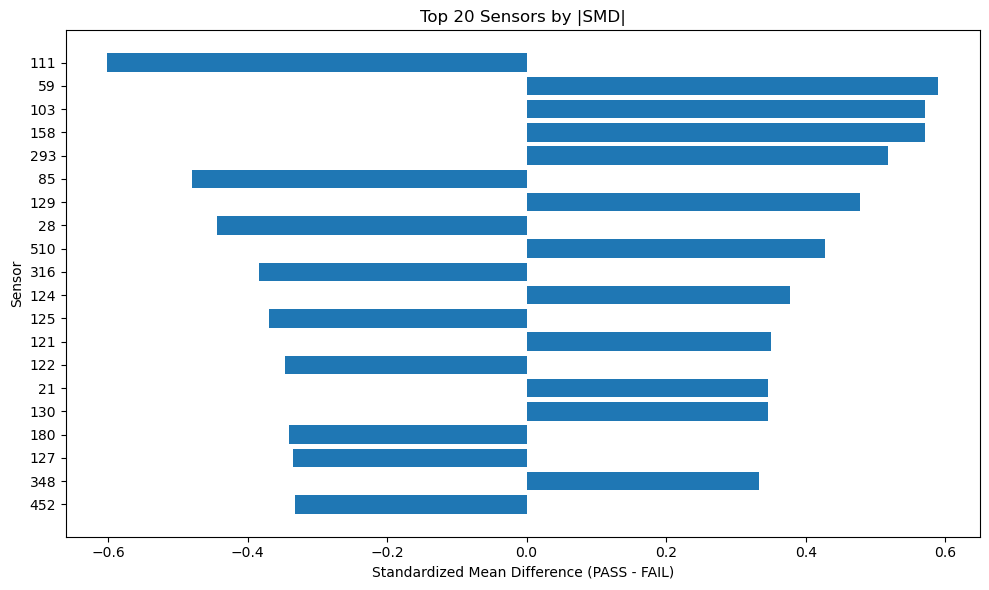

In [9]:
# === Plot: Top-|SMD| Sensors ===
top_n = 20
top_effect = effects_df.copy().dropna(subset=['SMD'])
top_effect = top_effect.loc[top_effect['SMD'].abs().sort_values(ascending=False).head(top_n).index]

plt.figure(figsize=(10,6))
plt.barh(top_effect.index.astype(str), top_effect['SMD'].values)
plt.xlabel('Standardized Mean Difference (PASS - FAIL)')
plt.ylabel('Sensor')
plt.title(f'Top {top_n} Sensors by |SMD|')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


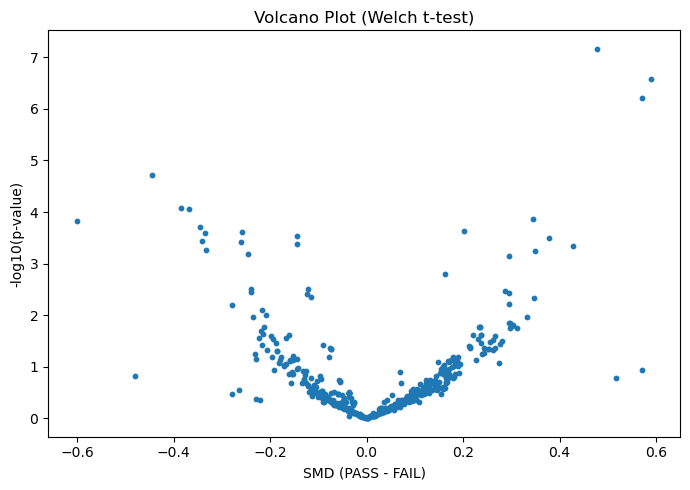

In [10]:
# === Plot: Volcano (-log10 p vs SMD) ===
if 'p_value' in effects_df.columns:
    ev = effects_df.dropna(subset=['SMD', 'p_value']).copy()
    ev['neglog10_p'] = -np.log10(ev['p_value'].replace(0, np.nan))
    plt.figure(figsize=(7,5))
    plt.scatter(ev['SMD'].values, ev['neglog10_p'].values, s=10)
    plt.xlabel('SMD (PASS - FAIL)')
    plt.ylabel('-log10(p-value)')
    plt.title('Volcano Plot (Welch t-test)')
    plt.tight_layout()
    plt.show()
else:
    print("無 p 值可用，略過火山圖。")


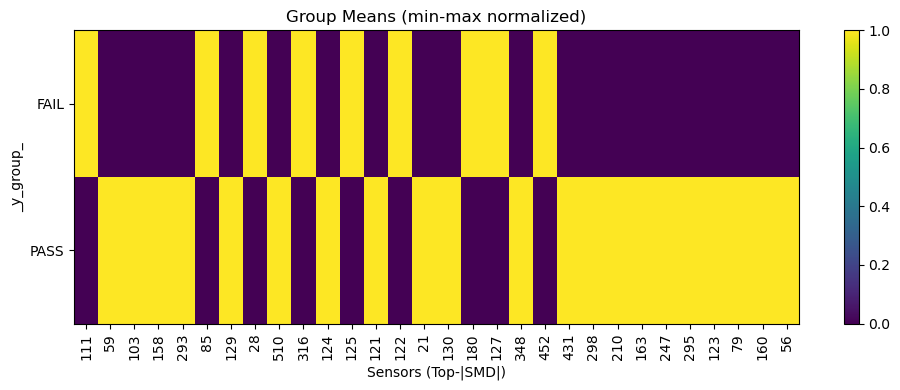

In [11]:
# === Heatmap: Group Means of Top Sensors ===
K = 30
ranked = effects_df['SMD'].abs().sort_values(ascending=False).head(K).index.tolist()
means = gstats['mean'].loc[:, ranked]

# Min-max 標準化（按欄位）
means_norm = (means - means.min()) / (means.max() - means.min())

plt.figure(figsize=(10, 4))
plt.imshow(means_norm.values, aspect='auto', interpolation='nearest')
plt.yticks(range(len(means_norm.index)), means_norm.index)
plt.xticks(range(len(means_norm.columns)), [str(c) for c in means_norm.columns], rotation=90)
plt.xlabel('Sensors (Top-|SMD|)')
plt.ylabel('_y_group_')
plt.title('Group Means (min-max normalized)')
plt.colorbar()
plt.tight_layout()
plt.show()


In [12]:
# === Notes & Next Steps ===
print("""說明：
- SMD > 0 代表 PASS 群體的均值高於 FAIL；SMD < 0 則相反。
- 若 scipy 不可用，請於本地環境安裝 `scipy` 以取得 t 檢定與 p 值（`pip install scipy`）。
- 可將 Top-|SMD| 感測器用於後續特徵選取或建模，並搭配 PCA/t-SNE 作低維可視化。
- 多重比較已使用 Benjamini–Hochberg 控制 FDR（若有 p 值）。
""")

說明：
- SMD > 0 代表 PASS 群體的均值高於 FAIL；SMD < 0 則相反。
- 若 scipy 不可用，請於本地環境安裝 `scipy` 以取得 t 檢定與 p 值（`pip install scipy`）。
- 可將 Top-|SMD| 感測器用於後續特徵選取或建模，並搭配 PCA/t-SNE 作低維可視化。
- 多重比較已使用 Benjamini–Hochberg 控制 FDR（若有 p 值）。

